# Importing libraries

In [1]:
import sys
sys.path.append('../')
from dataset import *
from data_aug import *
import tensorflow as tf
from comparison_model import *
from utils import *
from ranking_model import *

import random
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Subtract, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Loading data

In [2]:
image1_array, image2_array, labels = load_data("../data/question_1/Npy")

# Creating dataset

In [3]:
batch_size = 64

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "comparison")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

# Redefining the model for the tuning process

In [4]:
# Define hyperparameter search space with wider ranges
hyperparameters = {
    'dense_units': [32, 64, 128, 256, 512],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6],
    'learning_rate': [0.0001, 0.00001, 0.000001],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'learning_rate_decay': [0.001, 0.0001, 0.00001]
}

def comparison_siamese_model(input_shape, dense_units, dropout_rate, learning_rate, optimizer, learning_rate_decay, activation):
    """Create a siamese model for image comparison using VGG19 as base model.

    Args:
        input_shape (tuple): Shape of the input images.
        dense_units (int): Number of units in the dense layers.
        dropout_rate (float): Dropout rate.
        learning_rate (float): Learning rate for the optimizer.
        optimizer (str): Optimizer algorithm.
        activation (str): Activation function for the dense layers.

    Returns:
        keras.models.Model: The compiled siamese model.
    """
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-4]:
        layer.trainable=False

    # Create inputs for pairs of images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    # Get embeddings of the images using the shared VGG19 model
    output_1 = base_model(input_1)
    output_2 = base_model(input_2)

    concat = concatenate([output_1, output_2])

    # Classification layer to predict similarity
    flatten = Flatten()(concat)
    x = Conv2D(dense_units, (3, 3), activation=activation, padding='same')(concat)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(dense_units, (3, 3), activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    output = Dense(2, activation='sigmoid')(x)

    # Create the complete siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    if optimizer == "adam":
        optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay)
    elif optimizer == "sgd":
        optimizer = SGD(learning_rate=learning_rate, decay=learning_rate_decay)
    elif optimizer == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate, decay=learning_rate_decay)
    else:
        raise ValueError("Unsupported optimizer: " + optimizer)

    # Compile the model with the provided hyperparameters
    siamese_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    # Print model summary
    siamese_model.summary()

    return siamese_model


# Tuning process

{'dense_units': 512, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'adam', 'activation': 'sigmoid', 'learning_rate_decay': 1e-05}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_2[0][0]                    
                                                                 input_3[0][0]                    
___________________________________________________

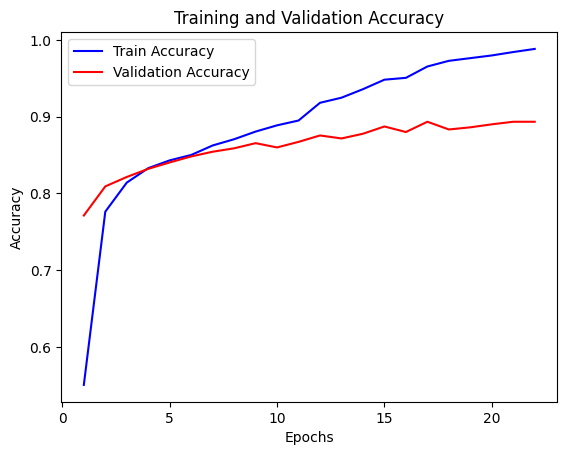

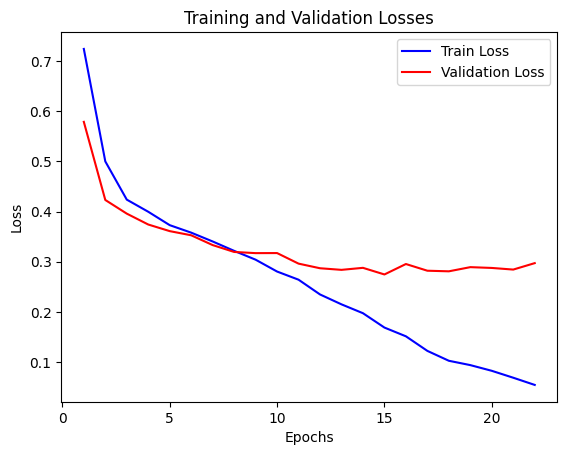

Best Hyperparameters: {'dense_units': 512, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'adam', 'activation': 'sigmoid', 'learning_rate_decay': 1e-05}
Best Test Loss: 0.3845643401145935
{'dense_units': 128, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'rmsprop', 'activation': 'relu', 'learning_rate_decay': 0.0001}
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 51

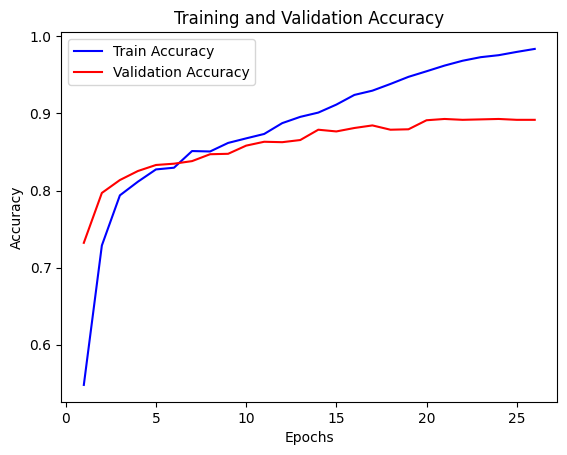

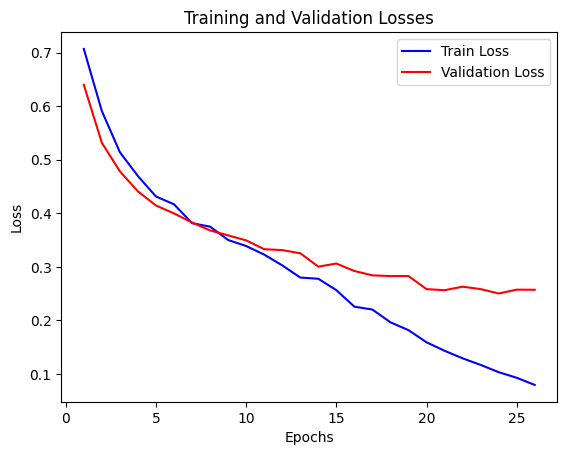

Best Hyperparameters: {'dense_units': 64, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'adam', 'activation': 'sigmoid', 'learning_rate_decay': 1e-05}
Best Test Loss: 0.3030979037284851
{'dense_units': 512, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'rmsprop', 'activation': 'relu', 'learning_rate_decay': 0.0001}
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 51

KeyboardInterrupt: 

In [5]:
# Initialize best hyperparameters and best validation accuracy
best_hyperparameters = None
best_test_loss = 100

# Define the number of random combinations to try
num_random_combinations = 70

# Perform random search
for _ in range(num_random_combinations):
    # Generate random combination of hyperparameters
    combination = {
        param: random.choice(values)
        for param, values in hyperparameters.items()
    }
    print(combination)
    # Create and train the model with the current hyperparameters
    model = comparison_siamese_model((224,224,3), **combination)
    
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

    # Train the model
    history = model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=50,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch,
          callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, steps=valid_steps_per_epoch)
    
    # Check if the current model has the best test accuracy so far
    if best_test_loss > test_loss:
        best_hyperparameters = combination
        best_test_loss = test_loss
        # Save the weights of the best model
        model.save_weights('best_model_weights.h5')
        plot_accuracy(history)
        plot_loss(history)

        # Print the best hyperparameters and best test accuracy
        print('Best Hyperparameters:', best_hyperparameters)
        print('Best Test Loss:', best_test_loss)



# Picked model

In [8]:
def comparison_siamese_model(input_shape):
    """Create a siamese model for image comparison using VGG19 as base model.

    Args:
        input_shape (tuple): Shape of the input images.
    Returns:
        keras.models.Model: The compiled siamese model.
    """
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-4]:
        layer.trainable=False

    # Create inputs for pairs of images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    # Get embeddings of the images using the shared VGG19 model
    output_1 = base_model(input_1)
    output_2 = base_model(input_2)

    concat = concatenate([output_1, output_2])

    # Classification layer to predict similarity
    flatten = Flatten()(concat)
    x = Conv2D(32, (3, 3), activation="tanh", padding='same')(concat)
    x = Dropout(0.3)(x)
    x = Conv2D(32, (3, 3), activation="tanh", padding='same')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    output = Dense(2, activation='sigmoid')(x)

    # Create the complete siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    # Compile the model with the provided hyperparameters
    siamese_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-05, decay=0.001), metrics=['accuracy'])

    # Print model summary
    siamese_model.summary()

    return siamese_model

siamese_model = comparison_siamese_model((224,224,3))

siamese_model.summary()

history = siamese_model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=50,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch,
          callbacks=[early_stopping])

siamese_model.save("handpicked_siamese_modle.h5")

test_loss, test_acc = siamese_model.evaluate(test_generator, steps=valid_steps_per_epoch)

Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_188 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_189 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_188[0][0]                  
                                                                 input_189[0][0]                  
__________________________________________________________________________________________________
concatenate_62 (Concatenate)    (None, 7, 7, 1024)   0           vgg19[0][0]               

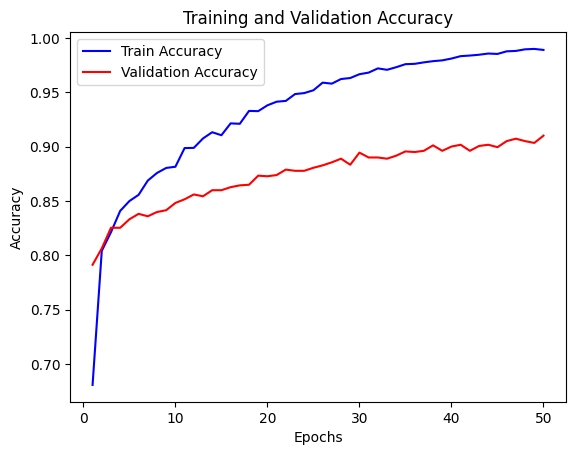

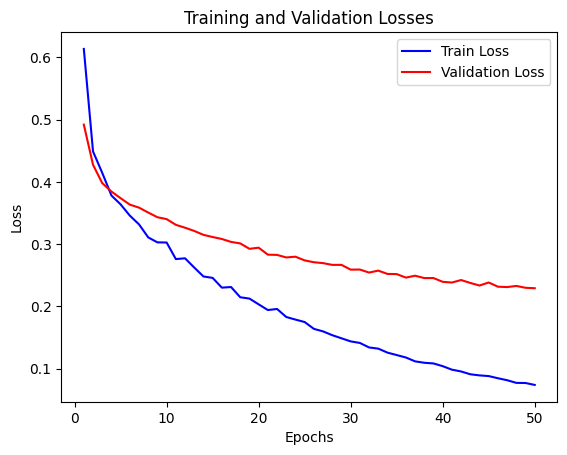

In [9]:
plot_accuracy(history)

plot_loss(history)